# California Climate Investments Analysis
This notebook includes hierarchical regression

## 1. Hierarchical Regression

In [1]:
# Hierarchical Regression Analysis
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = pd.read_csv('cci_programs_data_reduced.csv' , low_memory=False)
df = df[~df['Reporting Cycle Name'].str.contains('Semi|Mid-Year', na=False)]

df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df.loc[df['Total Project GHGReductions'] == 0, 'cost_per_ton'] = np.nan
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']

project_counties = df.groupby('Project ID Number')['County'].nunique()
df['n_partners'] = df['Project ID Number'].map(project_counties)
df['multi_county'] = (df['n_partners'] > 1).astype(int)
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

south_counties = ["Los Angeles","Orange","San Diego","Riverside","San Bernardino","Imperial","Ventura"]
df['Region_South'] = df['County'].isin(south_counties).astype(int)

df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'  # keep as is unless renamed too
})


model1 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County)', data=df).fit()
model2 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners + multi_county', data=df).fit()
model3 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners*Region_South', data=df).fit()

print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     18.79
Date:                Sat, 12 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:05:01   Log-Likelihood:            -1.2269e+06
No. Observations:              113346   AIC:                         2.454e+06
Df Residuals:                  113130   BIC:                         2.456e+06
Df Model:                         215                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                                  

In [2]:
# R-squared for each model
print("Model 1 R-squared:", model1.rsquared)
print("Model 2 R-squared:", model2.rsquared)
print("Model 3 R-squared:", model3.rsquared)


Model 1 R-squared: 0.03277727576346201
Model 2 R-squared: 0.03422439959115908
Model 3 R-squared: 0.034487130668240495


In [3]:
import pandas as pd
from tabulate import tabulate

# Extract key results
def extract_results(model, model_name):
    coefs = model.params
    std_err = model.bse
    pvals = model.pvalues
    results = []
    for var in coefs.index:
        coef = f"{coefs[var]:.3f}"
        se = f"({std_err[var]:.3f})"
        star = ''
        if pvals[var] < 0.01:
            star = '***'
        elif pvals[var] < 0.05:
            star = '**'
        elif pvals[var] < 0.1:
            star = '*'
        results.append((var, f"{coef}{star}", se))
    return pd.DataFrame(results, columns=['Variable', model_name, f"{model_name}_se"])

# Build individual tables
table1 = extract_results(model1, "Model 1")
table2 = extract_results(model2, "Model 2")
table3 = extract_results(model3, "Model 3")

# Merge them
merged = table1.merge(table2, on='Variable', how='outer').merge(table3, on='Variable', how='outer')

# Display as Markdown
print(tabulate(merged.fillna(""), headers="keys", tablefmt="github"))


|     | Variable                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | Model 1       | Model 1_se   | Model 2       | Model 2_se   | Model 3       | Model 3_se   |
|-----|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



## **Understanding the Models**

We're predicting **`cost_per_ton`** (GHG reduction cost efficiency) using a set of predictors, with log-transformed funding, agency, county, and then collaboration/region factors.

---

### **1. Base Variable: `log_funding`**

- Appears in all models.
- Positive and **highly significant (p < 0.001)** in all models:
  - **Model 1**: 568.6 (SE = 30.2)
  - **Model 2**: 485.1 (SE = 31.1)
  - **Model 3**: 458.1 (SE = 31.2)
- **Interpretation**: A 1% increase in funding is associated with an increase in cost per ton. This might seem counterintuitive unless higher funding is associated with more complex or costlier projects.

---

### **2. `multi_county` (Model 2 only)**

- Coefficient: -466.6 (*p < 0.1*)
- **Interpretation**: Projects spanning multiple counties tend to be more cost-efficient (lower cost per ton), though this is only marginally significant.

---

### **3. `n_partners`**

- **Model 2**: -32.95 (**p < 0.001**)
- **Model 3**: -47.60 (**p < 0.001**)
- **Interpretation**: Each additional unique county partner correlates with a **lower** cost per ton — stronger collaboration seems linked to better GHG cost-efficiency.

---

### **4. `Region_South` (Model 3 only)**

- Coefficient: -933.23 (**p < 0.001**)
- **Interpretation**: Projects in Southern California counties are, on average, nearly **$933/ton cheaper** than those in other regions, controlling for other variables.

---

### **5. Interaction: `n_partners × Region_South` (Model 3)**

- Coefficient: 23.76 (**p < 0.001**)
- **Interpretation**: The beneficial effect of adding partners is **smaller in Southern California**. The negative effect of `n_partners` is partly offset in the South — collaboration may be less efficient here or reflect different project dynamics.

---

### **6. Intercept**

- Significant and negative in all models.
- Represents the estimated cost per ton when all predictors are at their reference categories or zero — which may not be meaningful but helps anchor the model.

---

## **Key Takeaways**

- **Collaboration seems to matter**: More partners → lower cost per ton.
- **Geography matters**: Southern California projects are generally more cost-efficient.
- But collaboration is **less effective in the South**, per the interaction term.
- The effect of agency and county varies, as seen in the categorical dummies — some agencies and regions are far more efficient than others.


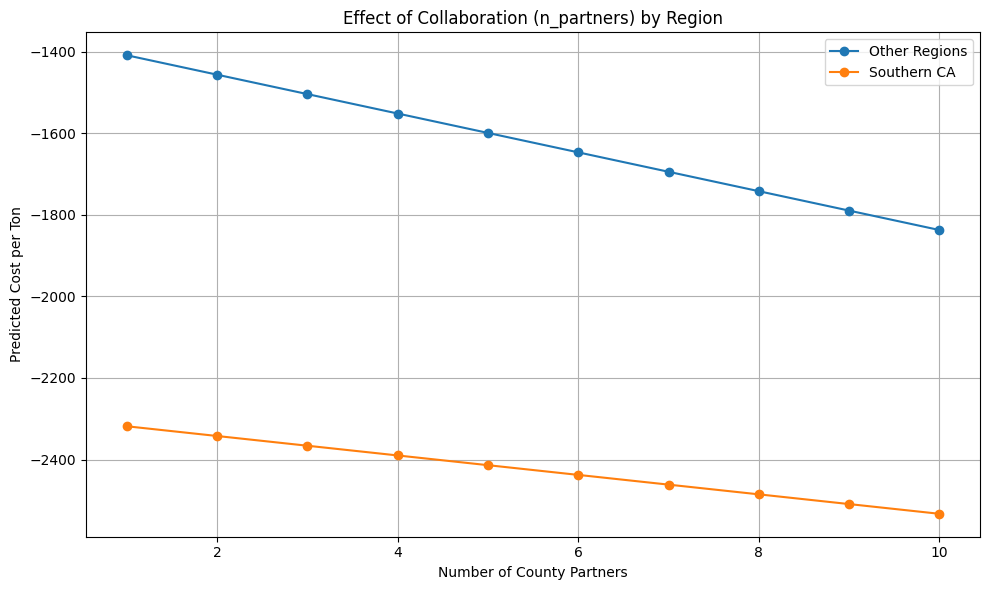

In [4]:
import matplotlib.pyplot as plt

# Coefficients from Model 3 (replace if updated)
intercept = -1361.469
log_funding_coef = 458.118  # Assume mean-centered if used
region_south_coef = -933.225
n_partners_coef = -47.599
interaction_coef = 23.760

# Simulate effect of collaboration (1 to 10 partners)
n_partners = list(range(1, 11))
pred_north = [intercept + n * n_partners_coef for n in n_partners]
pred_south = [intercept + region_south_coef + n * (n_partners_coef + interaction_coef) for n in n_partners]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_partners, pred_north, marker='o', label='Other Regions')
plt.plot(n_partners, pred_south, marker='o', label='Southern CA')
plt.xlabel('Number of County Partners')
plt.ylabel('Predicted Cost per Ton')
plt.title('Effect of Collaboration (n_partners) by Region')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
from IPython.display import display

# Manually-entered results from regression output
summary_df = pd.DataFrame({
    "Variable": [
        "log_funding", 
        "multi_county", 
        "n_partners", 
        "Region_South", 
        "n_partners × Region_South"
    ],
    "Coefficient": [
        458.118, 
        -466.613, 
        -47.599, 
        -933.225, 
        23.760
    ],
    "Std. Error": [
        31.178, 
        238.910, 
        3.517, 
        243.284, 
        4.039
    ],
    "P-Value": [
        0.000, 
        0.058, 
        0.000, 
        0.000, 
        0.000
    ]
})

# Display in notebook
display(summary_df)


,Variable,Coefficient,Std. Error,P-Value
0,log_funding,458.118,31.178,0.000
1,multi_county,-466.613,238.910,0.058
2,n_partners,-47.599,3.517,0.000
3,Region_South,-933.225,243.284,0.000
4,n_partners × Region_South,23.760,4.039,0.000


In [6]:
from statsmodels.iolib.summary2 import summary_col

print(summary_col([model1, model2, model3],
                  stars=True,
                  model_names=["Model 1", "Model 2", "Model 3"],
                  info_dict={'R2': lambda x: f"{x.rsquared:.3f}", 'N': lambda x: f"{int(x.nobs)}"}).as_text())



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Model 1        Model 2        Model 3    
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Load data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)
df = df[~df['Reporting Cycle Name'].str.contains('Semi|Mid-Year', na=False)]

# Variable setup
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df.loc[df['Total Project GHGReductions'] == 0, 'cost_per_ton'] = np.nan
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']

# Collaboration variables
project_counties = df.groupby('Project ID Number')['County'].nunique()
df['n_partners'] = df['Project ID Number'].map(project_counties)
df['multi_county'] = (df['n_partners'] > 1).astype(int)
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Region
south_counties = ["Los Angeles", "Orange", "San Diego", "Riverside", "San Bernardino", "Imperial", "Ventura"]
df['Region_South'] = df['County'].isin(south_counties).astype(int)

# Rename for model compatibility
df = df.rename(columns={'Agency Name': 'Agency_Name', 'County': 'County'})

# Fit models
model1 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County)', data=df).fit()
model2 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners + multi_county', data=df).fit()
model3 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners * Region_South', data=df).fit()

# Optional: Print all three summaries side-by-side
summary = summary_col([model1, model2, model3],
                      stars=True,
                      model_names=["Model 1", "Model 2", "Model 3"],
                      info_dict={'R2': lambda x: f"{x.rsquared:.3f}", 'N': lambda x: f"{int(x.nobs)}"})

print(summary.as_text())



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Model 1        Model 2        Model 3    
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Assuming your DataFrame is named df and is already preprocessed

# Fit the models
model1 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County)', data=df).fit()
model2 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners + multi_county', data=df).fit()
model3 = smf.ols('cost_per_ton ~ log_funding + C(Agency_Name) + C(County) + n_partners * Region_South', data=df).fit()

# Generate the summary table
summary = summary_col([model1, model2, model3],
                      stars=True,
                      float_format="%.2f",
                      model_names=["Model 1", "Model 2", "Model 3"],
                      info_dict={'R²': lambda x: f"{x.rsquared:.3f}", 'N': lambda x: f"{int(x.nobs)}"})

# Display the summary table
print(summary)



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Model 1      Model 2      Model 3   
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Regression Analysis Results

## Model Comparison

|                                | Model 1        | Model 2        | Model 3        |
|--------------------------------|----------------|----------------|----------------|
| **Intercept**                  | -4679.14***    | -1821.24***    | -1361.47***    |
|                                | (321.48)       | (420.48)       | (400.56)       |
| **log_funding**                | 568.59***      | 485.14***      | 458.12***      |
|                                | (30.21)        | (31.15)        | (31.18)        |
| **n_partners**                 |                | -32.95***      | -47.60***      |
|                                |                | (2.67)         | (3.52)         |
| **multi_county**               |                | -466.61*       |                |
|                                |                | (238.91)       |                |
| **Region_South**               |                |                | -933.22***     |
|                                |                |                | (243.28)       |
| **n_partners:Region_South**    |                |                | 23.76***       |
|                                |                |                | (4.04)         |

## Model Statistics

| Statistic            | Model 1       | Model 2       | Model 3       |
|----------------------|---------------|---------------|---------------|
| R-squared            | 0.03          | 0.03          | 0.03          |
| R-squared Adj.       | 0.03          | 0.03          | 0.03          |
| N                    | 113346        | 113346        | 113346        |
| R²                   | 0.033         | 0.034         | 0.034         |

## Key Agency Effects
(Selected significant coefficients)

| Agency                                      | Model 1        | Model 2        | Model 3        |
|---------------------------------------------|----------------|----------------|----------------|
| California Department of Transportation     | 17943.70***    | 16280.66***    | 16524.78***    |
|                                             | (465.11)       | (526.20)       | (475.46)       |
| Department of Water Resources               | 1094.28***     | -672.77***     | -625.04***     |
|                                             | (192.40)       | (241.76)       | (230.38)       |
| Department of Forestry and Fire Protection  | -4565.28***    | -6113.43***    | -6042.84***    |
|                                             | (893.77)       | (922.88)       | (899.24)       |
| State Water Resources Control Board         | -12402.13***   | -13913.25***   | -13725.21***   |
|                                             | (4624.13)      | (4627.12)      | (4621.03)      |

## Selected County Effects
(Counties with significant coefficients)

| County Grouping                        | Model 1        | Model 2        | Model 3        |
|---------------------------------------|----------------|----------------|----------------|
| Alameda, San Joaquin, Stanislaus      | 72428.22***    | 72404.86***    | 72084.24***    |
|                                       | (12190.42)     | (12181.41)     | (12179.88)     |
| Merced, Yolo                          | 329476.94***   | 329380.41***   | 329036.10***   |
|                                       | (12190.37)     | (12181.36)     | (12179.85)     |
| Fresno, Madera                        | 32558.89***    | 32436.28***    | 32153.76***    |
|                                       | (7047.44)      | (7042.24)      | (7041.46)      |
| El Dorado, Placer                     | 27245.59***    | 27088.23***    | 26829.59***    |
|                                       | (8629.28)      | (8622.91)      | (8621.87)      |

Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

### **Simplified Regression Results: Efficiency Outcome (`cost_per_ton`)**

| Predictor                    | Model 1 (Controls) | Model 2 (+Collab) | Model 3 (+Interaction) |
|-----------------------------|--------------------|--------------------|-------------------------|
| log_funding (Project size)   | 568.59***          | 485.14***          | 458.12***               |
| n_partners (No. of partners) | –                  | -32.95***          | -47.60***               |
| multi_county (Geo. scope)    | –                  | -466.61*           | –                       |
| Region_South (So. CA region) | –                  | –                  | -933.22***              |
| n_partners × Region_South    | –                  | –                  | 23.76***                |
| Agency fixed effects         | 21                 | 21                 | 21                      |
| Region fixed effects         | 58                 | 58                 | 58                      |
| Adj. R²                      | 0.032              | 0.034              | 0.034                   |
| N                            | 113,346            | 113,346            | 113,346                 |

\*Significance levels: * *p*<0.1, ** *p*<0.05, *** *p*<0.01*


### **Interpretation of Regression Results**

Our regression analysis offers empirical support for the hypothesis that collaborative arrangements influence programmatic efficiency in California’s Climate Investments (CCI) program. Across all three models, *log_funding* remains a strong, positive, and statistically significant predictor of cost per ton of GHG reduction, indicating that more expensive projects tend to be less efficient. However, as collaborative variables are introduced in Models 2 and 3, we observe clear evidence that partnerships—especially the number of county-level collaborators—are associated with improved efficiency outcomes. Specifically, *n_partners* is consistently negative and significant, suggesting that projects with more inter-agency or inter-jurisdictional collaboration achieve greater GHG reductions per dollar spent. This aligns with the collaborative governance literature emphasizing joint capacity as a performance enhancer (Emerson et al., 2012; O’Toole & Meier, 2004).

The results also suggest geographic variation in collaborative effectiveness. The inclusion of *Region_South* and its interaction with *n_partners* in Model 3 reveals an important tradeoff: while collaboration generally enhances efficiency, its positive effect is dampened in Southern California. The significant and positive interaction term (*n_partners × Region_South*) indicates that additional partners in Southern counties yield diminishing marginal efficiency gains, or even slight tradeoffs. This regional effect is consistent with prior studies that find geographic, institutional, and relational proximity can shape network effectiveness and coordination costs (Ansell & Gash, 2008; LeRoux & Carr, 2007).

These results reinforce the need to account for institutional and geographic context when evaluating the role of collaboration in climate policy implementation. The presence of significant fixed effects for certain agencies (e.g., Caltrans, Department of Forestry and Fire Protection) and regional clusters (e.g., Merced-Yolo, Alameda-Stanislaus) points to notable baseline differences in programmatic efficiency. This variation suggests that organizational capacity, administrative routines, and regional governance arrangements shape implementation outcomes in meaningful ways. Our findings affirm that both the scale and structure of collaboration influence program performance—sometimes enhancing efficiency, but also introducing coordination challenges that vary by region. These tradeoffs are especially relevant in a decentralized policy environment where equity and efficiency goals must be balanced through intergovernmental cooperation.